<a href="https://colab.research.google.com/github/salmanromeo/1D_Pitching_Moment/blob/main/1D_Pitching_Moment_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Applying Reinforcement Learning for 1D Pitching Moment Equation**

\begin{align}
  α = f(M, C_{m_q}+C_{m_α},t)
    \end{align}
#####Where the main issue is **$C_{m_q}+C_{m_α}$** is non-linear and there exist a non-linear relationship between **$α$** and **$t$**. In low $α$ and Mach number, their fluctuates over time is more complex than high $α$. Given such a complicated environment, we cannot afford just training models on the datasets we have and pushing it to fit those data accurately. The learning of reinforcement learning should start with simplified scenarios, where we can fit those data.

**A brief introduction to reinforcement learning**

#####The main two parts of the reinforcement learning framework are:
1.   Environment: this is a “playing field”, in our case oscillation, which can tell us what’s happening right now and what will be our reward in the future if we do some action right now.
2.   Agent: a “player”, that interacts with the environment and learns how to maximize long-term rewards via doing different actions in different situations.

#####Graphically, it can be represented on the following diagram:
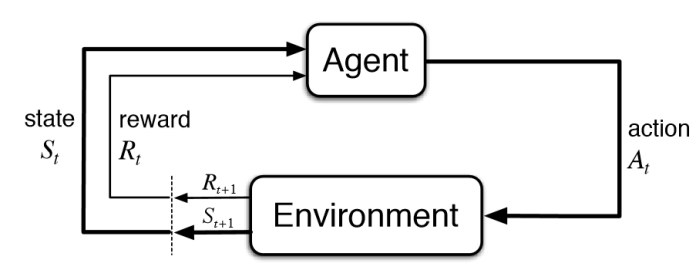


**Implementation of the Environment and Agent**

#####— Iterate over N epochs, where each epoch is iteration overall environment
#####— For each sample in the environment:
1.   Get the current state at time $t$
1.   Get the value function for all actions at this state (our neural network will output 3 values for us)
1.   Do an action on this state (or argmax the outputs or act randomly to explore)
2.   Get the reward for this action from the environment (see the class)
2.   Get the next state after the current one (for the future long-term rewards)
2.   Save a tuple of the current state, next state, value function, and reward for experience replay
1.   Do the experience replay — fit our Q neural network on some samples from the experience replay buffer to make the Q function more adequate with respect to which rewards we will get for which actions at this step





**Simplified exercise**

To evaluate this a simple cosine function can help us — if we can fit such data, we can start from here and make the environment gradually harder and harder for our agent.

In [210]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow.keras as tfk

import collections

**Environment**

In [211]:
class Environment:
    '''
        Simple environment
    '''
    def __init__(self, length = 100, normalize = True, noise = True, data = []):
        self.length = length

        if len(data) == 0:
            # self.data = -pd.DataFrame(np.arange(self.length))
            self.data = pd.DataFrame(np.sin(np.arange(length)/30.0))
        else:
            self.data = data

        if noise:
            self.data += pd.DataFrame(np.random.normal(0, 0.1, size=(length, )))

        if normalize:
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        window = self.data.iloc[time-lookback:time]
        if diff: window = window.diff().fillna(0.0)
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        # 0 => long; 1 => hold, 2 => short
        if action == 0:
            action = 1
        elif action == 1:
            action = 0
        else:
            action = -1
        price_now = self.data.iloc[action_time]
        price_reward = self.data.iloc[reward_time]
        price_diff = (price_reward - price_now) / price_now
        reward = np.sign(price_diff) * action * coef

        return reward.values.tolist()[0]

**Agent**

In [212]:
class OscillationAgent:
    '''
        A simple agent
    '''
    def __init__(self, state_shape = 10, action_shape = 3, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.model = self.init_model()
        self.experience = collections.deque(maxlen=self.experience_size)

    def init_model(self):
        inputs = tfk.Input(shape=(self.state_shape,))
        x = tfk.layers.Dense(10, activation='relu')(inputs)
        outputs = tfk.layers.Dense(self.action_shape, activation='linear')(x)
        model = tfk.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=tfk.optimizers.Adam(0.1), loss='mse', metrics='mse')
        return model

    def save_experience(self, state_i, q_value_i, action_i, reward_i, state_i_1):
        self.experience.append({
            'state_i': state_i,
            'q_value_i': q_value_i,
            'action_i': action_i,
            'reward_i': reward_i,
            'state_i_1': state_i_1
        })

    def replay_experience(self, alpha, gamma, sample_size):
        X, Y = [], []
        indices_sampled = np.random.choice(len(self.experience), sample_size, replace=False)
        for i, e in enumerate(self.experience):
            if i in indices_sampled:
                state_i, action_i, reward_i, q_value_i = e['state_i'], e['action_i'], e['reward_i'], e['q_value_i']
                state_i_1 = e['state_i_1']
                q_value_i_1 = self.model.predict(np.expand_dims(state_i_1, 0))[0]
                y_i = np.zeros(self.action_shape)
                y_i[:] = q_value_i[:]
                y_i[action_i] = (1 - alpha) * y_i[action_i] + alpha * (reward_i + gamma * max(q_value_i_1))
                X.append(state_i)
                Y.append(y_i)
        X, Y = np.array(X), np.array(Y)
        self.model.fit(X, Y, epochs=1, batch_size=sample_size, verbose=0)

    def get_value_action_value(self, state):
        pred = self.model.predict(np.expand_dims(state, 0))
        return pred.flatten()

In [213]:
agent = OscillationAgent()

In [214]:
agent.get_value_action_value(
    pd.DataFrame(np.array(range(10)))
)

1/1 [==============================] - 0s 57ms/step


array([-3.2008088,  1.1317918, -2.4325027], dtype=float32)

**Training**

In [215]:
epochs = 5
gamma = 0.9
epsilon = 0.95
alpha = 0.9

In [217]:
DATASET_LENGTH = 300
WINDOW_SHAPE = 5
REWARD_TIME = 1
ACTIONS_SHAPE = 3
SAMPLE_SIZE = 16

In [218]:
environment = Environment(DATASET_LENGTH, True, False)
agent = OscillationAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

In [ ]:
for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, DATASET_LENGTH - REWARD_TIME, REWARD_TIME): 

        # 1. getting current state
        state_j = environment.get_state(j, WINDOW_SHAPE)
        q_value_j = agent.get_value_action_value(state_j)

        # 2. acting in this state
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = (np.argmax(q_value_j))    

        # 3. getting reward from this action
        reward_value_j = environment.get_reward(action, j, j+REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. getting next state and value there
        state_j_1 = environment.get_state(j+1, WINDOW_SHAPE)

        # 5. save this experience
        agent.save_experience(state_j, q_value_j, action, reward_value_j, state_j_1)

        if j > SAMPLE_SIZE * 2:
            # 6. train on samples from experience
            agent.replay_experience(alpha, gamma, SAMPLE_SIZE)

    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

**Evaluation**

In [220]:
action_to_backtest_action = {
    0: 1,
    1: 0,
    2: -1
}

**Validating our strategy**

#####Let’s see if within such a framework we can train our agent to ride a cosine wave. Let’s define some parameters that we will use to train our agent:

#####— Training will be done for 5 epochs
#####— Epsilon = 0.95, Gamma = 0.9, Alpha = 0.9
#####— The length of the environment is 300 points, every state length is 5 points
#####— Every state is normalized using differencing the time series
#####— The reward is updated every 1 point (i.e. next observation at t+1)
#####— We have three actions (long, short, flat) with the reward multiplied by +100, 0, and -100 accordingly
#####— For experience replay, we will use 16 samples from our buffer

**Dataset without Noise**

In [ ]:
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    state_j = environment.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

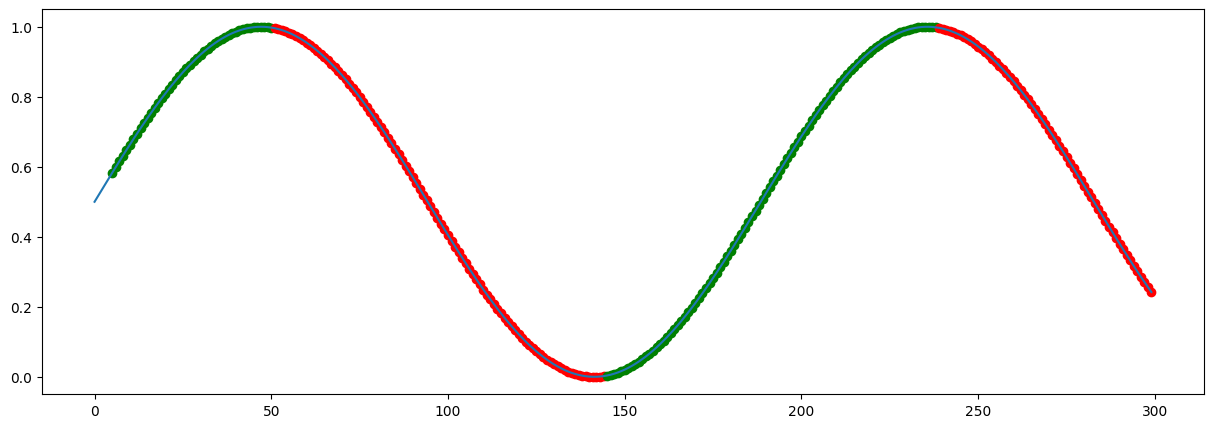

In [222]:
plt.figure(figsize = (15, 5))
plt.plot(environment.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

#####First, let’s check our cosine function — and it looks great! Seems like we are being long (green dots) exactly in the “bullish” parts of the cosine actions and do the opposite on the other side!

**Dataset with Noise**

In [ ]:
environment = Environment(DATASET_LENGTH, True, True)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    state_j = environment.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

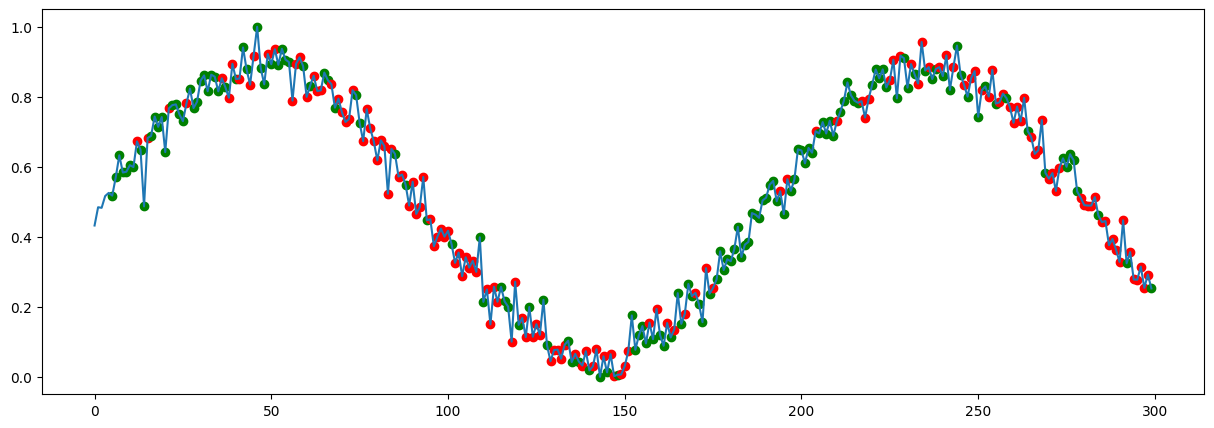

In [233]:
plt.figure(figsize = (15, 5))
plt.plot(environment.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

#####Let’s make the exercise a bit harder now and add some Gaussian noise to the time series without retraining the model. And it still works adequately! Now there are some confusion points, but on average the model still knows where the long-term trends of our noisy cosine function are.

**1D Pitching Moment Dataset**

#####Let’s make life for our agent even more complicated — let’s add more sine functions with different frequency periods and try to trade those combined waves.

In [238]:
y_data = np.load('/content/sample_data/rdata_test.npy')
t_data = np.load('/content/sample_data/tdata_test.npy')

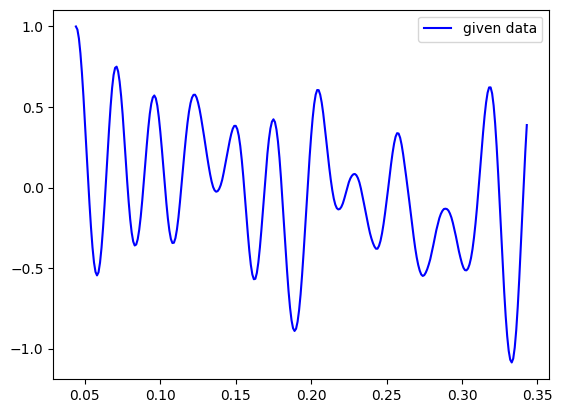

In [239]:
plt.plot(t_data, y_data, 'b', label='given data')
plt.legend()
plt.show()

In [240]:
data_alp = pd.DataFrame(y_data)

In [ ]:
environment = Environment(DATASET_LENGTH, True, False, data_alp)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME): 
    state_j = environment.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

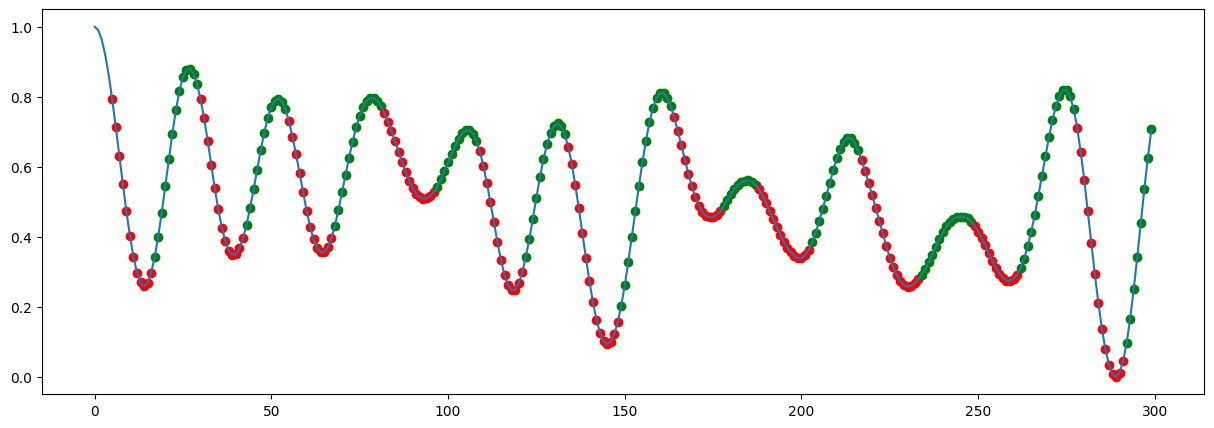

In [246]:
plt.figure(figsize = (15, 5))
plt.plot(environment.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

#####The result is still great — our representation of the oscillation is clearly representing the trends and even if our model was trained on another kind of data, it still knows what to do with another kind of wave.

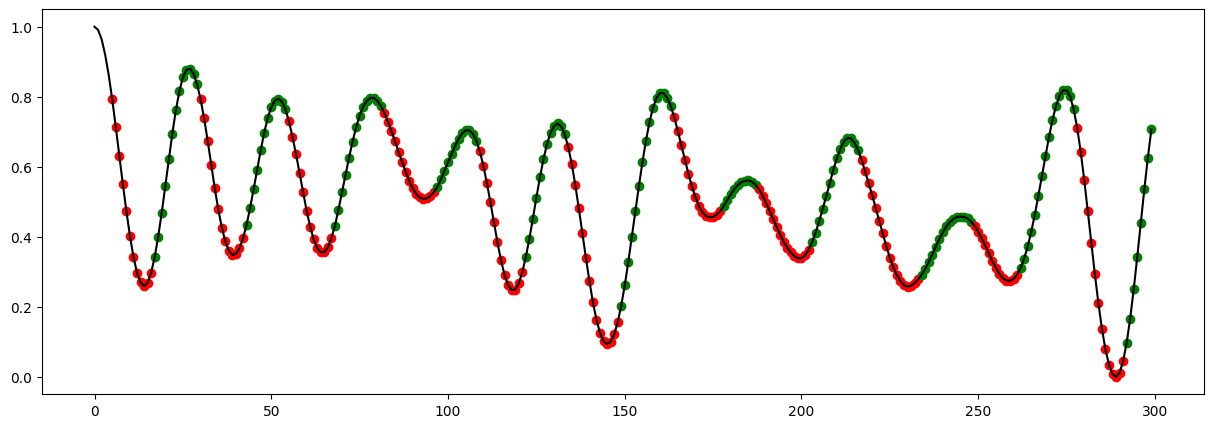

In [247]:
from PIL import Image
import glob

! rm -rf forgif
! mkdir forgif

plt.figure(figsize = (15, 5))
plt.plot(environment.data, color = 'black')
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data.iloc[e], color = 'red')
    else:
        pass
    plt.savefig('./forgif/i_' + str(e).zfill(4) + '.jpg')

frames = []
imgs = glob.glob("./forgif/*.jpg")
frames = [Image.open(i) for i in sorted(imgs)]

# Save into a GIF file that loops forever
frames[0].save(
    'png_to_gif.gif', format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=100, loop=0)